# Sequential rumour stance prediction

Rumours tend to change over time; people focus on different aspects of a story.<br>
We could view this process as a word space distribution that evolves over time. 

## Semi-supervised subspace alignment

Here we will tackle this problem using a semi-supervised variant of a [Subspace Aligned Classifier](https://www.cv-foundation.org/openaccess/content_iccv_2013/papers/Fernando_Unsupervised_Visual_Domain_2013_ICCV_paper.pdf).

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import pickle as pc
import dateutil
import numpy.random as rnd
from scipy.spatial.distance import pdist, squareform

# Import feature extractors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize.api import StringTokenizer
from nltk.tokenize import TweetTokenizer

# Import visualizers
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Import classifiers
from sklearn import svm
from sklearn import linear_model
from subalign import SemiSubspaceAlignedClassifier

# Import class imbalance techniques
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline

from IPython.core.debugger import Tracer

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set font size
fS = 20

In [3]:
# Experimental parameters
which_rumour = 'charliehebdo'
classifier = 'lr'
kernel = 'poly'
degree = 3
l2 = None
subspace_dim = 50

In [4]:
# Load data
X = np.load('../data/RumEval2019/rumeval19.npy')
tweets = pd.read_json('../data/RumEval2019/RumEval19.json')

X[np.isnan(X)] = 0

In [5]:
# Show rumours
rumours_ = tweets['rumour'].tolist()
rumours = np.unique(tweets['rumour'].tolist())
[print(rumour) for rumour in rumours];

# Show dates
# dates_ = [dateutil.parser.parse(date).date() for date in tweets['date'].tolist()]
dates_ = [date.date() for date in tweets['date'].tolist()]
dates = np.unique(dates_)

charliehebdo
ebola-essien
ferguson
germanwings-crash
illary
ottawashooting
prince-toronto
putinmissing
sydneysiege


## Sequential prediction over rumours

In [6]:
# Load data
X = np.load('../data/RumEval2019/rumeval19.npy')
tweets = pd.read_json('../data/RumEval2019/RumEval19.json')

X[np.isnan(X)] = 0

In [7]:
# Process data

# Subselect labels and map to numerical
labels_ = tweets['label'].values.tolist()
labels = np.unique(labels_)
Y = np.array([np.argwhere(label == labels)[0][0] for label in labels_])
K = len(np.unique(Y))

# Sort tweets by time
tweets = tweets.sort_values(by=['date'])
dates_ = tweets['date'].values
dates = np.unique(tweets['date'].values)
sortix = np.argsort(dates_)

rumours_ = tweets['rumour'].values[sortix]
indexes = np.unique(rumours_, return_index=True)[1]
all_rumours = [rumours_[index] for index in sorted(indexes)]

# Remove rumours with too few samples
cutoff = subspace_dim
rumours = []
for rumour in all_rumours:
    
    # Number of samples for current rumour
    num_rumour = np.sum(rumours_ == rumour)
    
    if num_rumour >= cutoff:
        rumours.append(rumour)
        
print('{} rumours discarded for having less than {} samples.\n'.format(len(all_rumours) - len(rumours), cutoff))

print('Remaining rumours:')
[print(rumour) for rumour in rumours]

# Sort embedding
X = X[sortix, :]

nR = len(rumours)

1 rumours discarded for having less than 50 samples.

Remaining rumours:
ferguson
ottawashooting
prince-toronto
sydneysiege
charliehebdo
putinmissing
germanwings-crash
illary


In [8]:
# Number of repetitions of the experiment
nI = 1

# Preallocate performance array
nperf_array = np.zeros((nR-2, nI))
aperf_array = np.zeros((nR-2, nI))
sub_dim_r = np.zeros((nR-2, nI))
mappings = []

# Start iterating
for n in range(nI):
    
    print('At repetition {}/{}'.format(n, nI))

    # Start looping over rumours
    for r in range(1, len(rumours)-1):

        print('At rumour ' + rumours[r])

        # Set range up to yesterday
        past = slice(0,r)

        # Create training data from all past rumours
        trn_index = tweets['rumour'].isin(rumours[past]).values

        # Find all tweets from current rumour
        tst_index = (tweets['rumour'] == rumours[r]).values.tolist()

        # Split out training data
        trn_X = X[trn_index, :]
        trn_Y = Y[trn_index]

        # Split out test data
        tst_X = X[tst_index, :]
        tst_Y = Y[tst_index]

        # Set up under-sampling using specified classifier
        trn_X, trn_Y = RandomOverSampler().fit_resample(trn_X, trn_Y)

        # Check label proportions
        print('Label shape of train set, after resampling: \t %s' % Counter(trn_Y))

        # Sample size
        N = trn_X.shape[0]
        M = tst_X.shape[0]

        # Subspace dimensionality for today
        if n == 0:
            sub_dim_r[r-1] = min(subspace_dim, min(N, M))
            
        # Call adaptive classifier
        aclf = SemiSubspaceAlignedClassifier(l2_regularization=l2, subspace_dim=min(subspace_dim, min(N, M)))
        
        # Random selection of 1 target label per class for semi-supervision
        u = np.zeros((K, 2), dtype='uint8')
        for k in range(K):
            _, ix = aclf.find_medioid(tst_X, tst_Y == k)
            u[k, 0] = ix
            u[k, 1] = k

        # Semi-supervised alignment
        V, CX, CZ = aclf.semi_subspace_alignment(trn_X, trn_Y, tst_X, u, subspace_dim=min(subspace_dim, min(N, M)))
        
        # Keep mappings
        mappings.append(V)

        # Check if subspace was reduced
        if n == 0:
            sub_dim_r[r-1] = V[k].shape[1]

        # Define classifier
        if classifier in ('lr', 'logr', 'logistic'):
            
            if l2:

                # Linear logistic model
                nclf = linear_model.LogisticRegression(C=l2, multi_class='auto', solver='lbfgs')
                
            else:
                
                # Linear logistic model
                nclf = linear_model.LogisticRegressionCV(multi_class='auto', solver='lbfgs')

        elif classifier in ('svm', 'svc', 'rbfsvc'):

            # Polynomial support vector machine
            nclf = svm.SVC(kernel=kernel, gamma='auto', C=l2)

        else:
            raise ValueError('Classifier not recognized')

        # Train classifier on labeled data from previous days
        nclf.fit(trn_X, trn_Y)
        
        aclf.fit(trn_X, trn_Y, tst_X, u)

#         trn_XV = np.zeros((N, V[k].shape[1]))
#         for k in range(K):
#             trn_XV[trn_Y == k, :] = trn_X[trn_Y == k, :] @ CX[k] @ V[k]

#         # Train classifier on labeled data from previous days, aligned to unlabeled data from today
#         aclf.fit(trn_XV, trn_Y)

        # Make predictions on test set
        npreds = nclf.predict(tst_X)
        apreds = aclf.predict(tst_X)

        # Test on data from current day and store
        nperf_array[r-1, n] = np.mean(npreds == tst_Y);
        aperf_array[r-1, n] = np.mean(apreds == tst_Y)

# Compact to DataFrame
rum_results = pd.DataFrame({'rumours': rumours[1:-1],
                            'acc_naive': np.mean(nperf_array, axis=1),
                            'acc_adaptive': np.mean(aperf_array, axis=1),
                            'subspace_dim': sub_dim_r},
                           columns=['rumours', 'acc_naive', 'acc_adaptive', 'sub_dim_r'])    

At repetition 0/1
At rumour ottawashooting
Label shape of train set, after resampling: 	 Counter({3: 735, 2: 735, 0: 735, 1: 735})
Final regularization parameter = 1e-06
Final regularization parameter = 1e-06
Final regularization parameter = 9.999999999999999e-06
Final regularization parameter = 9.999999999999999e-06
Final regularization parameter = 9.999999999999999e-06
Final regularization parameter = 9.999999999999999e-06
Final regularization parameter = 9.999999999999999e-06
Final regularization parameter = 9.999999999999999e-06
Final regularization parameter = 9.999999999999999e-06
Final regularization parameter = 1e-06
Final regularization parameter = 1e-06
Final regularization parameter = 9.999999999999999e-06
Final regularization parameter = 9.999999999999999e-06
Final regularization parameter = 9.999999999999999e-06
Final regularization parameter = 9.999999999999999e-06
Final regularization parameter = 9.999999999999999e-06
Final regularization parameter = 9.999999999999999e-0

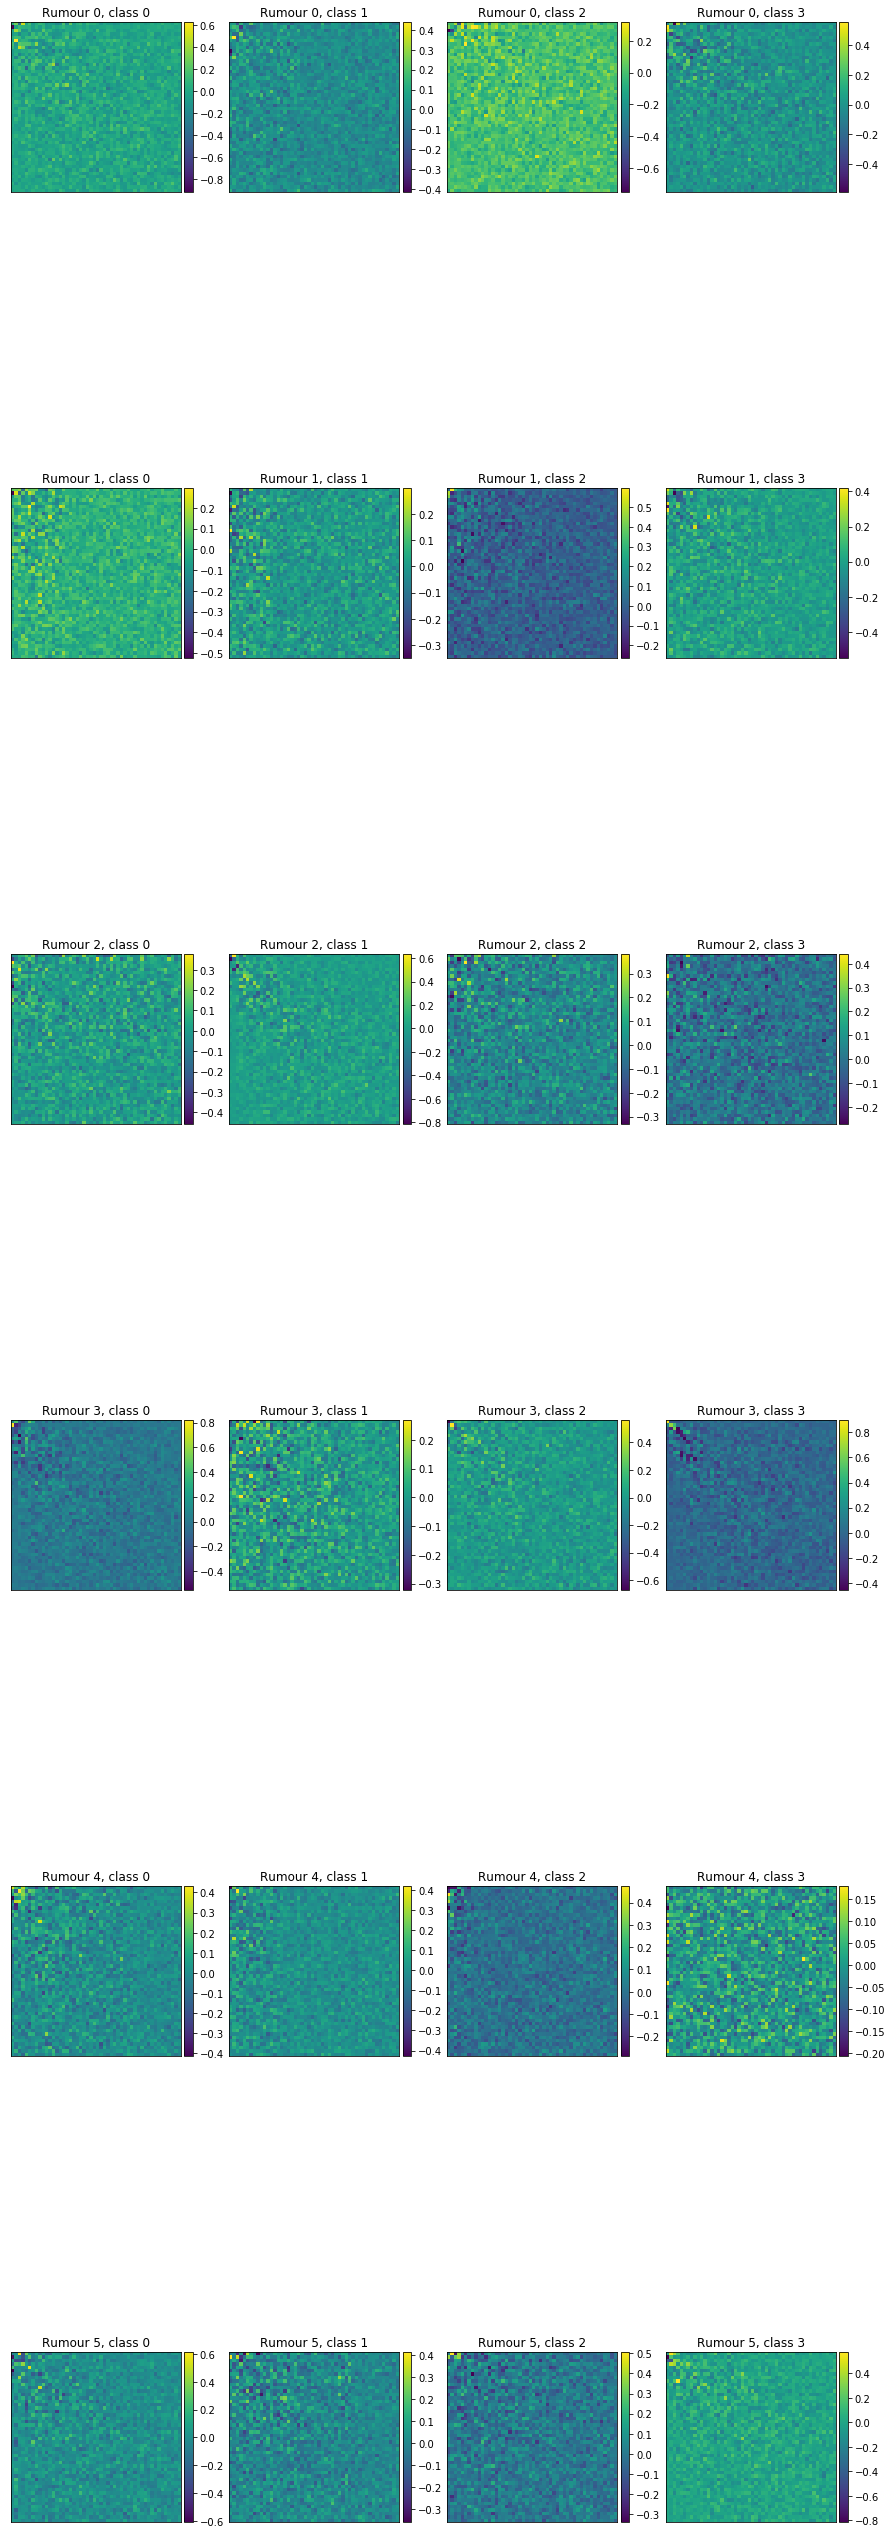

In [13]:
fig, ax = plt.subplots(nrows=len(mappings), ncols=K, sharex=True, sharey=True, figsize=(15,50))

for m, mapping in enumerate(mappings):
    for k in range(K):
        im = ax[m][k].imshow(mapping[k])
        divider = make_axes_locatable(ax[m][k])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax[m][k].get_xaxis().set_visible(False)
        ax[m][k].get_yaxis().set_visible(False)
        ax[m][k].set_title('Rumour {}, class {}'.format(m, k))
        
fig.savefig('exp-stance_rumEval19_semisubalign_dim' + str(subspace_dim) + '_mappings.png', bbox_inches='tight', padding=None)

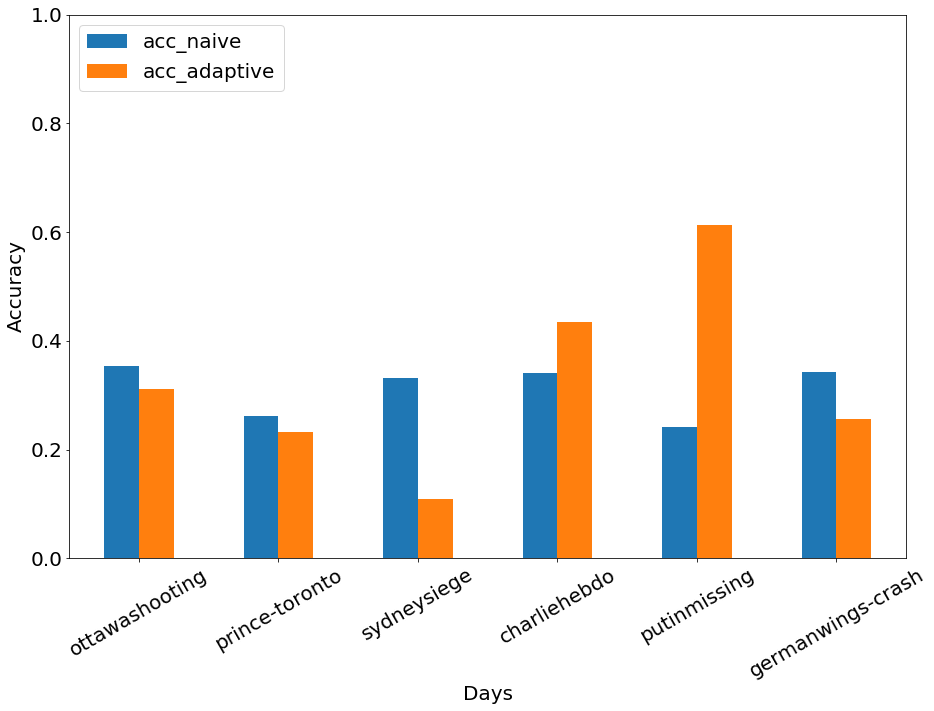

In [14]:
# Visualize performance in bar graph

# Initialize figure
fig, ax = plt.subplots(figsize=(15, 10))

# Bar plot
rum_results.plot.bar(ax=ax, x='rumours', y=["acc_naive", "acc_adaptive"], rot=30, fontsize=fS, legend=True);

# Set axes properties
ax.set_ylim([0, 1]);
ax.legend(fontsize=fS, loc=2);
ax.set_xlabel('Days', fontsize=fS);
ax.set_ylabel('Accuracy', fontsize=fS);

fig.savefig('exp-stance_rumEval19_semisubalign_dim' + str(subspace_dim) + '_bar-rumours.png', bbox_inches='tight', padding=None)

In [ ]:
# Initialize figure
fig, ax = plt.subplots(nrows=len(rumours)-2, ncols=3, sharex=True, sharey=True, figsize=(30, 40))

# Start looping over rumours
for r in range(1, len(rumours)-1):
    
    print('At rumour ' + rumours[r])
    
    # Set range up to yesterday
    past = slice(0,r)

    # Create training data from all previous days
    trn_index = tweets['rumour'].isin(rumours[past]).values

    # Find all tweets from today
    tst_index = (tweets['rumour'] == rumours[r]).values.tolist()

    # Split out training data
    trn_X = X[trn_index, :]
    trn_Y = Y[trn_index]

    # Split out test data
    tst_X = X[tst_index, :]
    tst_Y = Y[tst_index]
    
    # Find subspace
    clf = SemiSubspaceAlignedClassifier(subspace_dim=2)
            
    # Random selection of 1 target label per class for semi-supervision
    u = np.zeros((K, 2), dtype='uint8')
    for k in range(K):
        _, ix = aclf.find_medioid(tst_X, tst_Y == k)
        u[k, 0] = ix
        u[k, 1] = k

    # Semi-supervised alignment
    V, CX, CZ = clf.semi_subspace_alignment(trn_X, trn_Y, tst_X, u, subspace_dim=2)
    
    X_ = np.zeros((trn_X.shape[0], CX[k].shape[1]))
    XV = np.zeros((trn_X.shape[0], V[k].shape[1]))
    for k in range(K):
        X_[trn_Y == k, :] = trn_X[trn_Y == k, :] @ CX[k]
        XV[trn_Y == k, :] = trn_X[trn_Y == k, :] @ CX[k] @ V[k]
    
    # Map target data onto components 
    Z_ = tst_X @ CZ
    
    for l, label in enumerate(labels):

        ax[r-1][0].scatter(X_[(trn_Y == l), 0], X_[(trn_Y == l), 1], label=label)
        ax[r-1][0].set_title('Past rumours (' + ', '.join(rumours[past]) + ')')
        ax[r-1][0].set_xlabel('p_1')
        ax[r-1][0].set_ylabel('p_2')
        ax[r-1][0].legend(fontsize=fS)
        
        ax[r-1][1].scatter(XV[(trn_Y == l), 0], XV[(trn_Y == l), 1], label=label)
        ax[r-1][1].set_title('Transformed')
        ax[r-1][1].set_xlabel('p_1')
        ax[r-1][1].set_ylabel('p_2')
        ax[r-1][1].legend(fontsize=fS)
        
        ax[r-1][2].scatter(Z_[(tst_Y == l), 0], Z_[(tst_Y == l), 1], label=label)
        ax[r-1][2].set_title(rumours[r])
        ax[r-1][2].set_xlabel('p_1')
        ax[r-1][2].set_ylabel('p_2')
        ax[r-1][2].legend(fontsize=fS)
    
plt.savefig('exp-stance_rumEval19_subalign_rumours.png', bbox_inches=None, padding='tight')    
plt.show()

## Sequential prediction over days

In [ ]:
# Subselect labels and map to numerical
labels_ = tweets['label'].values.tolist()
labels = np.unique(labels_)
Y = np.array([np.argwhere(label == labels)[0][0] for label in labels_])

In [ ]:
# Select dates
dates_ = tweets['date'].values

all_dates = np.unique(dates_)

# Remove dates with too few samples
cutoff = 10
dates = []
for date in all_dates:
    
    # Number of samples for current date
    num_date = np.sum(dates_ == date)
    
    if num_date > cutoff:
        dates.append(date)
        
print('{} dates discarded for having less than {} samples.'.format(len(all_dates) - len(dates), cutoff))

Maybe it would be a good idea to forget older rumours. Like an exponentially decaying weighting.

In [ ]:
# Classification experiment

# Preallocate performance array
nperf_array = []
aperf_array = []
days_array = []
sub_dim_d = []
mappings = []

# Loop over days
for d in range(1, len(dates)-1):

    # Set range up to yesterday
    past = slice(d)

    # Create training data from all previous days
    trn_index = tweets['date'].isin(dates[past]).values

    # Find all tweets from today
    tst_index = (tweets['date'] == dates[d]).values.tolist()

    # Split out training data
    trn_X = X[trn_index, :]
    trn_Y = Y[trn_index]

    # Split out test data
    tst_X = X[tst_index, :]
    tst_Y = Y[tst_index]
    
    # Set up under-sampling using specified classifier
    trn_X, trn_Y = RandomOverSampler().fit_resample(trn_X, trn_Y)
    
    # Check label proportions
    print('Label shape of train set, after resampling: \t %s' % Counter(trn_Y))
    
    # Sample size
    N = trn_X.shape[0]
    M = tst_X.shape[0]
    
    # Store subspace dimensionality
    sub_dim_d.append(min(subspace_dim, min(N, M)))
    
    # Adaptive classifier
    aclf = SemiSubspaceAlignedClassifier()
                
    # Random selection of 1 target label per class for semi-supervision
    u = np.zeros((K, 2), dtype='uint8')
    for k in range(K):
        _, ix = aclf.find_medioid(tst_X, tst_Y == k)
        u[k, 0] = ix
        u[k, 1] = k

    # Semi-supervised alignment
    V, CX, CZ = clf.semi_subspace_alignment(trn_X, trn_Y, tst_X, u, subspace_dim=min(subspace_dim, min(N, M)))
    
    # Store mappings
    mappings.append(V)
    
    # Define classifier
    if classifier in ('lr', 'logr', 'logistic'):
        
        # Linear logistic model
        nclf = linear_model.LogisticRegression(C=l2, multi_class='auto', solver='lbfgs')
        aclf = linear_model.LogisticRegression(C=l2, multi_class='auto', solver='lbfgs')
        
    elif classifier in ('svm', 'svc', 'rbfsvc'):
        
        # Polynomial support vector machine
        nclf = svm.SVC(kernel=kernel, gamma='auto', C=l2)
        aclf = svm.SVC(kernel=kernel, gamma='auto', C=l2)
        
    else:
        raise ValueError('Classifier not recognized')

    # Train classifier on labeled data from previous days
    nclf.fit(trn_X, trn_Y)
    
    # Train classifier on labeled data from previous days, aligned to unlabeled data from today
    aclf.fit(trn_X, trn_Y)

    # Make predictions on test set
    npreds = nclf.predict(tst_X)
    apreds = aclf.predict(tst_X)

    # Test on data from current day and store
    nperf_array.append(np.mean(npreds == tst_Y))
    aperf_array.append(np.mean(apreds == tst_Y))

# Compact to DataFrame
results = pd.DataFrame({'dates': dates[1:-1],
                        'acc_naive': nperf_array,
                        'acc_adaptive': aperf_array,
                        'subspace_dim': sub_dim_d},
                        columns=['dates', 'acc_naive', 'acc_adaptive', 'subspace_dim'])    
results

In [ ]:
# Visualize performance in bar graph

# Initialize figure
fig, ax = plt.subplots(figsize=(15, 50))

# Bar plot
results.plot.barh(ax=ax, x='dates', y=["acc_naive", "acc_adaptive"], fontsize=fS, legend=True);

# Set axes properties
# ax.set_ylim([0, 1]);
ax.legend(fontsize=fS, loc=1);
ax.set_ylabel('Days', fontsize=fS);
ax.set_xlabel('Accuracy', fontsize=fS);

fig.savefig('exp-stance_rumEval19_semisubalign' + str(subspace_dim) + '_bar-dates-allrumours.png', bbox_inches='tight', padding=None)